# Cathy RL

In [46]:
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [47]:
data = pd.read_csv("./Data/cathy.csv").astype('float32')
data.head()

,0,1,2,3,4,5,6,7,8,9,...,16374,16375,16376,16377,16378,16379,16380,16381,16382,16383
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [48]:
# 3D Vector 변환
width, height, channel = 128,128,1
x_train = data.values
x_train = x_train.reshape((x_train.shape[0],width,height,channel))
print(x_train.shape)

(18, 128, 128, 1)


In [49]:
# image pixel normalization [0,255] -> [-1,1] (hyperbolic tangent 사용, tanh는 -1에서 1까지의 범위)
X = (x_train-127.5)/127.5
print(X[0])

[[[-1.]
  [-1.]
  [-1.]
  ...
  [-1.]
  [-1.]
  [-1.]]

 [[-1.]
  [-1.]
  [-1.]
  ...
  [-1.]
  [-1.]
  [-1.]]

 [[-1.]
  [-1.]
  [-1.]
  ...
  [-1.]
  [-1.]
  [-1.]]

 ...

 [[-1.]
  [-1.]
  [-1.]
  ...
  [-1.]
  [-1.]
  [-1.]]

 [[-1.]
  [-1.]
  [-1.]
  ...
  [-1.]
  [-1.]
  [-1.]]

 [[-1.]
  [-1.]
  [-1.]
  ...
  [-1.]
  [-1.]
  [-1.]]]


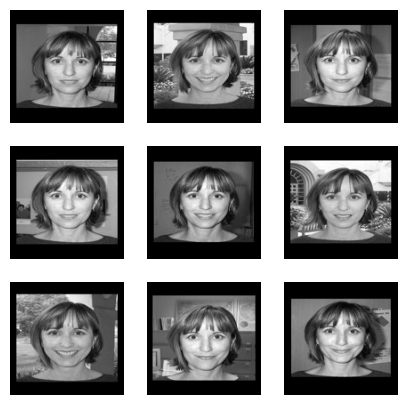

In [50]:
# 이미지 시각화
plt.figure(figsize=(5,5))

i = 1
for image in X:
    plt.subplot(3,3,i)
    image = image.reshape(width,height)
    plt.imshow(image,cmap='gray')
    plt.axis('off')
    i+=1
    if i > 9:break
plt.show()

In [51]:
import tensorflow as tf

In [52]:
# 학습 데이터 batch 준비
BATCH_SIZE = 64

# batch size로 나누기
train_dataset = tf.data.Dataset.from_tensor_slices(X).batch(BATCH_SIZE)
print(train_dataset)

<BatchDataset element_spec=TensorSpec(shape=(None, 128, 128, 1), dtype=tf.float32, name=None)>


### 생성자 모델

In [53]:
# Generator 모델 네트워크 구성

def build_generator_model():
    model = keras.Sequential() # Keras 모델 생성

    model.add(keras.layers.Dense(1024, input_dim=9, use_bias=False)) # 100 = 10*10
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.LeakyReLU())
    
    model.add(keras.layers.Dense(32*32*128, use_bias=False)) # 128 / 4 = 32
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.LeakyReLU())
    
    # Resahpe (7*7)
    model.add(keras.layers.Reshape((32,32, 128)))  # 128 / 4 = 32
    
    model.add(keras.layers.Conv2DTranspose(512, (5, 5), # 128 * 2 * 2
                                    strides=(1, 1), padding='same', use_bias=False))
    model.add(keras.layers.BatchNormalization()) 
    model.add(keras.layers.LeakyReLU())
    
    # (7*7) -> (14*14)
    model.add(keras.layers.Conv2DTranspose(256, (5, 5), # 128 * 2
                                    strides=(2, 2), padding='same', use_bias=False))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.LeakyReLU())
    
    # (14*14) -> (28*28)
    model.add(keras.layers.Conv2DTranspose(1, (5, 5), 
                                    strides=(2, 2), padding='same', activation='tanh'))
    assert model.output_shape == (None, 128, 128, 1)

    return model

In [54]:
# 생성자 모델 생성
generator = build_generator_model()
generator.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 1024)              9216      
                                                                 
 batch_normalization_12 (Bat  (None, 1024)             4096      
 chNormalization)                                                
                                                                 
 leaky_re_lu_18 (LeakyReLU)  (None, 1024)              0         
                                                                 
 dense_11 (Dense)            (None, 131072)            134217728 
                                                                 
 batch_normalization_13 (Bat  (None, 131072)           524288    
 chNormalization)                                                
                                                                 
 leaky_re_lu_19 (LeakyReLU)  (None, 131072)           

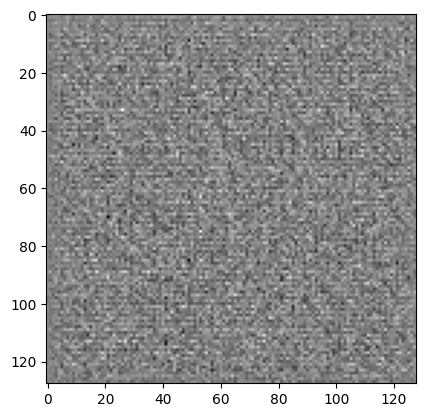

In [55]:
# 학습되지 않은 생성자 모델이 만든 이미지
noise = tf.random.normal([1,9]) # 100: 출력이미지 개수
generated_image = generator(noise,training=False) # noise를 가지고 training 없이 이미지 만들기
plt.imshow(generated_image[0,:,:,0],cmap='gray')
plt.show()

### 판별자 모델

In [56]:
# Discriminator 모델 네트워크 구성

def build_discriminator_model():

    model = keras.Sequential()
    
    model.add(keras.layers.Conv2D(256, (5, 5), strides=2, padding='same',  # 256 = 128 * 2
                       input_shape=[128, 128, 1])) # input image size
    model.add(keras.layers.LeakyReLU(0.2))
    model.add(keras.layers.Dropout(0.3))

    model.add(keras.layers.Conv2D(512, (5, 5), strides=2, padding='same')) # 512 = 256 * 2
    model.add(keras.layers.LeakyReLU(0.2))
    
    model.add(keras.layers.Flatten())
    
    model.add(keras.layers.Dense(1024)) # 1024 = 512 * 2
    model.add(keras.layers.LeakyReLU(0.2))
    model.add(keras.layers.Dropout(0.3))

    model.add(keras.layers.Dense(1))
    
    return model

In [57]:
# 판별자 모델 생성
discriminator = build_discriminator_model()
discriminator.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 64, 64, 256)       6656      
                                                                 
 leaky_re_lu_22 (LeakyReLU)  (None, 64, 64, 256)       0         
                                                                 
 dropout_4 (Dropout)         (None, 64, 64, 256)       0         
                                                                 
 conv2d_5 (Conv2D)           (None, 32, 32, 512)       3277312   
                                                                 
 leaky_re_lu_23 (LeakyReLU)  (None, 32, 32, 512)       0         
                                                                 
 flatten_2 (Flatten)         (None, 524288)            0         
                                                                 
 dense_12 (Dense)            (None, 1024)             

In [58]:
# 학습되지 않은 판별자의 결과
predicted = discriminator(generated_image)
print(predicted)

tf.Tensor([[-2.4695833e-06]], shape=(1, 1), dtype=float32)


### Optimizer

In [59]:
# Optimizer 생성
# 생성자용
generator_optimizer = keras.optimizers.Adam(1e-4)

# 판별자용
discriminator_optimizer = keras.optimizers.Adam(1e-4)

# Binary Crossentropy for minMax
cross_entropy = keras.losses.BinaryCrossentropy(from_logits=True)

In [60]:
# Generator Loss 함수
# 생성자 모델의 목표: 판별자 모델이 가짜 이미지를 판별했을 때 판별값이 1에 가까워지도록 Fake Image 생성
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output),fake_output)

# Discriminator Loss 함수
# 판별자 모델의 목표: 1. 진짜 이미지를 판별했을 떄 판별값이 1에 가까워지도록; 2. 가짜 이미지를 판별했을 때 판별값이 0에 가까워지도록

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output),real_output) # 1과 진짜 이미지 판별값 비교
    fake_loss = cross_entropy(tf.zeros_like(fake_output),fake_output) # 0과 가짜 이미지 판별값 비교
    total_loss = real_loss+fake_loss
    return total_loss

In [61]:
# 학습값 설정
EPOCHS = 1000
noise_dim = 9
# 일반적으로 epochs와 noise_dim은 같게 함
# 근접한 숫자가 필요할 경우 noise dimension을 줄인다

In [62]:
# tf.function 에서는 파이썬 코드의 문장 실행 순서를 참조하여 실행 순서의 모호성을 해결합니다. tensorflow에서는 사용하는 것이 좋다.
@tf.function
def train_step(images):
    # 생성자 input noise
    noise = tf.random.normal([BATCH_SIZE, noise_dim])
    # Gradient descent 계산 및 파라미터 업데이트
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True) # 진짜 이미지를 봤을 때의 판별 값
      fake_output = discriminator(generated_images, training=True) # 가짜 이미지를 봤을 때의 판별 값

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [63]:
# 테스트 노이즈 시각화 함수

test_noise = tf.random.normal([9, noise_dim]) # 학습 시각화를 위한 테스트 노이즈 100개

def show_generated_images(epoch):
    images = generator.predict(test_noise)
    images = 0.5 * images + 0.5 # tanh는 sigmoid보다 데이터 범위가 2배가 더 크므로 이를 조정 
    
    plt.figure(figsize=(11,11))
    
    i = 1
    for image in images:
        image = image.reshape(width, height)
        plt.subplot(3,3, i)
        plt.imshow(image, cmap='gray')
        plt.axis('off')
        i+=1

    plt.suptitle("Generated Images on EPOCH: %s" % epoch, fontsize = 25)
    plt.show()


In [64]:
# 학습코드
def train(dataset,epochs):
    for epoch in range(epochs):
        for image_batch in dataset: # batch 학습 (64)
            train_step(image_batch)
        print("%s epochs trained"%epoch)
        if epoch % 5 == 0: # 5번 돌 때마다 시각화
            show_generated_images(epoch)


### 학습

2023-03-06 18:31:52.953955: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


0 epochs trained
1/1 [==============================] - 3s 3s/step


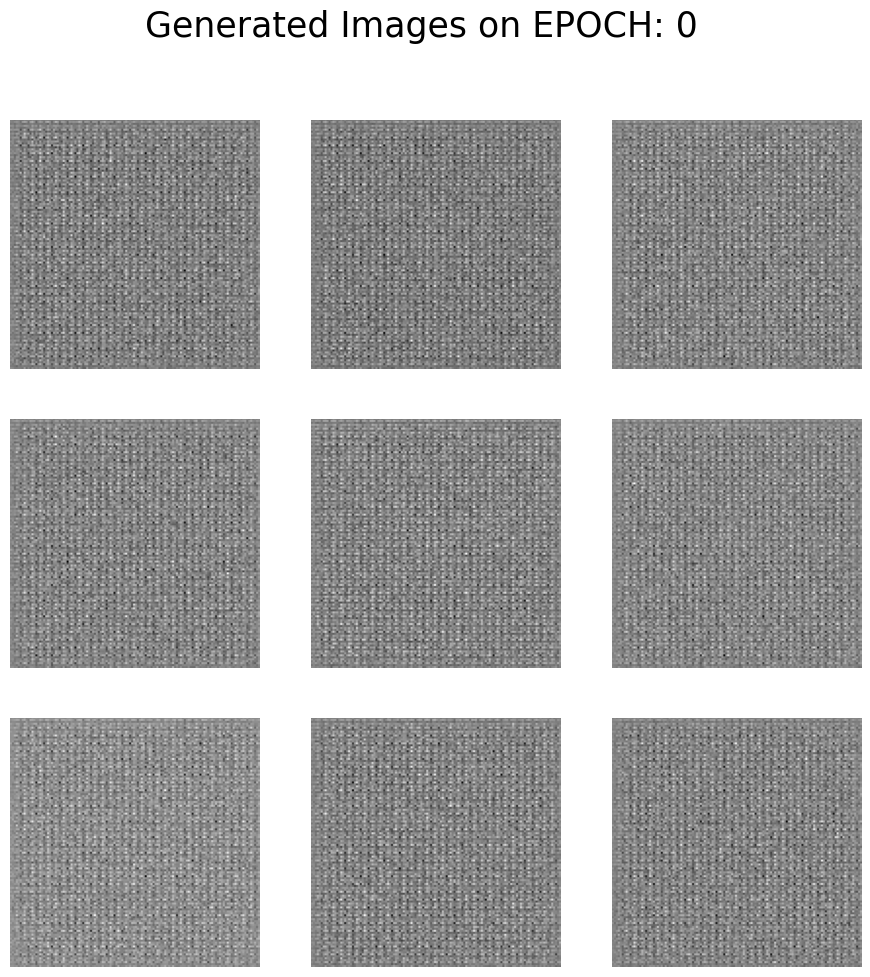

1 epochs trained
2 epochs trained


In [65]:
# 학습 시작
train(train_dataset,EPOCHS+1)